<a href="https://colab.research.google.com/github/lakshmanpadigala/SMAI_S22_5/blob/main/Cutout_and_ResNet18_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wget

In [ ]:
import numpy as np
import torch
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from tabulate import tabulate
from sklearn import preprocessing
import torch.nn as nn
import wget
import tarfile
from scipy.io import loadmat

In [ ]:
# url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
# train_file = wget.download(url)

In [ ]:
# url1 = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
# test_file = wget.download(url1)

In [ ]:
# !mv /content/test_32x32.mat /content/drive/MyDrive/Colab\ Notebooks/SMAI\ Project

In [ ]:
# !mv /content/train_32x32.mat /content/drive/MyDrive/Colab\ Notebooks/SMAI\ Project

In [ ]:
# train_file = tarfile.open('/content/drive/MyDrive/Colab Notebooks/SMAI Project/train.tar.gz')
# test_file = tarfile.open('/content/drive/MyDrive/Colab Notebooks/SMAI Project/test.tar.gz')
# train_file.extractall('/content/drive/MyDrive/Colab Notebooks/SMAI Project')
# test_file.extractall('/content/drive/MyDrive/Colab Notebooks/SMAI Project')
# train_file.close()
# test_file.close()

In [ ]:
train = loadmat('/content/drive/MyDrive/Colab Notebooks/SMAI Project/train_32x32.mat')

In [ ]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [ ]:
train_x = train['X'].T
train_y = train['y']
train_x.shape , train_y.shape

((73257, 3, 32, 32), (73257, 1))

In [ ]:
test = loadmat('/content/drive/MyDrive/Colab Notebooks/SMAI Project/test_32x32.mat')

In [ ]:
test_x = test['X'].T
test_y = test['y']
test_x.shape , test_y.shape

((26032, 3, 32, 32), (26032, 1))

In [ ]:
def cut_out(image,holes,patch_length):
  image =  torch.from_numpy(image)
  # print("Image shape",image.shape)
  height = image.shape[1]
  width = image.shape[2]
  for i in range(holes):
    y = np.random.randint(height)
    x = np.random.randint(width)
    mask = np.ones((height, width), np.float32)
    y1 = np.clip(y - patch_length // 2, 0, height)
    y2 = np.clip(y + patch_length // 2, 0, height)
    x1 = np.clip(x - patch_length // 2, 0, width)
    x2 = np.clip(x + patch_length // 2, 0, width)

    mask[y1: y2, x1: x2] = 0

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(image)
    image = image * mask

  return image      

In [ ]:
train_x[0].shape

(3, 32, 32)

In [ ]:
i1 = cut_out(train_x[0],1,8)
print(i1.shape)

torch.Size([3, 32, 32])


In [ ]:
train_x_8 = []
for image in train_x:
  train_x_8.append(cut_out(image,1,8))
# train_x_8 = torch.cat(train_x_8)

In [ ]:
test_x_8 = []
for image in test_x:
  test_x_8.append(cut_out(image,1,8))
# test_x_8_8 = torch.cat(test_x_8)

In [ ]:
train_x_8[0].shape

torch.Size([3, 32, 32])

In [ ]:
def display_images(imgs,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
      img = imgs[i-1].permute(1,2,0)
      fig.add_subplot(row, col, i)
      img = np.array(img)
      img = img / 256
      plt.imshow(img)
      plt.axis('off')
    plt.show()

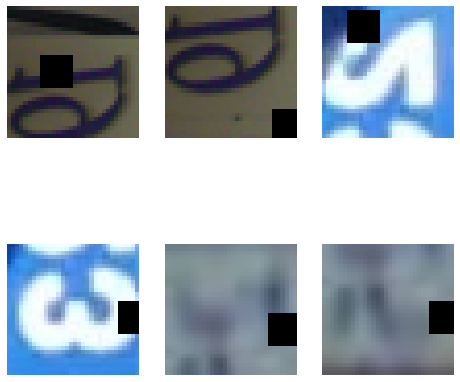

In [ ]:
display_images(train_x_8[:6],2,3)

In [ ]:
from tensorflow import keras
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPool2D
from keras.models import Model,load_model
from keras.initializers import glorot_uniform

In [ ]:
def identity_connection(x,k,filters_size,s):
  f1,f2 = filters_size

  x_temp = x

  x = Conv2D(filters = f1 , kernel_size = (k,k),strides = (s,s),padding = 'same')(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)

  x = Conv2D(filters = f2 , kernel_size = (k,k),strides = (1,1),padding = 'same')(x)
  x = BatchNormalization(axis=3)(x)

  # x = Activation('relu')(x)

  # x = Conv2D(filters = f3 , kernel_size = (k,k),strides = (1,1),padding = 'valid')(x)
  # x = BatchNormalization(axis=3)(x)

  if s!=1:
    x_temp = Conv2D(filters = f2,kernel_size = (1,1),strides = (s,s),padding='valid')(x_temp)
    x_temp = BatchNormalization(axis=3)(x_temp)

  x = Add()([x,x_temp])
  x = Activation('relu')(x)

  return x


In [ ]:
def ResNet18(input_shape = (32,32,3),classes = 10):
  x_input = Input(input_shape)
  x = ZeroPadding2D((3,3))(x_input)

  x = Conv2D(64,(7,7),strides = (2,2))(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)
  x = MaxPool2D((3,3),strides=(2,2),padding = 'same')(x)

  x = identity_connection(x,k=3,filters_size=[64,64],s=1)
  x = identity_connection(x,k=3,filters_size=[64,64],s=1)
  x = identity_connection(x,k=3,filters_size=[128,128],s=2)
  x = identity_connection(x,k=3,filters_size=[128,128],s=1)
  x = identity_connection(x,k=3,filters_size=[256,256],s=2)
  x = identity_connection(x,k=3,filters_size=[256,256],s=1)
  x = identity_connection(x,k=3,filters_size=[512,512],s=2)
  x = identity_connection(x,k=3,filters_size=[512,512],s=1)

  # x = AveragePooling2D((7,7),name = 'avg_pool')(x)

  x = Flatten()(x)

  x = Dense(classes,activation="softmax",kernel_initializer = glorot_uniform(seed=0))(x)

  model = Model(inputs = x_input,outputs = x,name = 'ResNet18')

  return model

In [ ]:
model = ResNet18(input_shape = (32,32,3),classes = 10)

In [ ]:
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 16, 16, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 64)  256         ['conv2d_20[0][0]']       

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])